## Part B: Analysing CSV Data

### Step 01: Import pyspark and initialize Spark

In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'

# Initialising pyspark by creating entry points to spark
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# Checking for existing spark context before creating a new one
sc = SparkContext.getOrCreate()

# Create a new spark context if there is no pre-existing spark context with required specifications about logical cores and application name
if (sc is None):
    sc = SparkContext(master="local[*]")

# Initialising spark session object used to create dataframes from various input sources
spark = SparkSession(sparkContext=sc)\
        .builder\
        .appName("MongoDB and Apache Spark")\
        .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.11:2.4.0")\
        .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/fit5202_db.ass1partb_coll")\
        .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/fit5202_db.ass1partb_coll")\
        .getOrCreate()


### Step 02: Create Dataframe

In [2]:
# Using spark session object to load the csv file
crime_df = spark.read.csv('Crime_Statistics_SA_2010_present.csv', inferSchema=True, header=True)
crime_df.show()

+-------------+-----------------+-------------------+---------------------------+---------------------------+---------------------------+-------------+
|Reported Date|Suburb - Incident|Postcode - Incident|Offence Level 1 Description|Offence Level 2 Description|Offence Level 3 Description|Offence Count|
+-------------+-----------------+-------------------+---------------------------+---------------------------+---------------------------+-------------+
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       FRAUD DECEPTION A...|       Obtain benefit by...|            2|
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       PROPERTY DAMAGE A...|       Other property da...|            2|
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       SERIOUS CRIMINAL ...|        SCT - Non Residence|            1|
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       

In [3]:
# Printing dataframe schema
crime_df.printSchema()

root
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Offence Count: integer (nullable = true)



In [4]:
# Printing the count of records present in the dataframe
print('The number of records in the dataframe are :', crime_df.count())

The number of records in the dataframe are : 727408


### Step 03: Write to Database

In [6]:
# Writing to mongoDB to use it as a data source 
crime_df.write.format("com.mongodb.spark.sql.DefaultSource").mode("overwrite").save()
crime_df.show()

+-------------+-----------------+-------------------+---------------------------+---------------------------+---------------------------+-------------+
|Reported Date|Suburb - Incident|Postcode - Incident|Offence Level 1 Description|Offence Level 2 Description|Offence Level 3 Description|Offence Count|
+-------------+-----------------+-------------------+---------------------------+---------------------------+---------------------------+-------------+
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       FRAUD DECEPTION A...|       Obtain benefit by...|            2|
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       PROPERTY DAMAGE A...|       Other property da...|            2|
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       SERIOUS CRIMINAL ...|        SCT - Non Residence|            1|
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       

### Step 04: Read from Database

In [7]:
# Creating a soark dataframe to hold data from the mongoDB collection
new_df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
new_df.describe().show()

+-------+------------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+
|summary|     Offence Count|Offence Level 1 Description|Offence Level 2 Description|Offence Level 3 Description|Postcode - Incident|Reported Date|Suburb - Incident|
+-------+------------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+
|  count|            727407|                     727407|                     727407|                     727407|             726926|       727407|           727247|
|   mean|1.1715174585892079|                       null|                       null|                       null| 5153.2510978611035|         null|             null|
| stddev|0.5787050930378087|                       null|                       null|                       null| 199.48097964732779|         null|             null|
|    min| 

### Step 05: Calculate the statistics of numeric and string columns

In [8]:
# Finding the statistical parameters 
new_df['Offence Count', 'Reported Date'].describe().show()

+-------+------------------+-------------+
|summary|     Offence Count|Reported Date|
+-------+------------------+-------------+
|  count|            727407|       727407|
|   mean|1.1715174585892079|         null|
| stddev|0.5787050930378049|         null|
|    min|                 1|    1/01/2011|
|    max|                28|    9/12/2018|
+-------+------------------+-------------+



* The minimum and the maximum reported date shown above is different from the actual minumum and maximum date.
* The possible reason for the wrong min and max of reported date shown could be that the column `Reported Date` is in string format, rather than being in date format. This can be observed by printing the dataframe schema.
* In the string format, the reported dates are converted into ascii values and then their minimum and maximum values are shown which would be different from the actual min and max date.

### Step 06: Change the data type of a column

In [9]:
# Importing libraries
from datetime import datetime
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType

# Creating user defined function which converts the string cell into a date
func =  udf(lambda x: datetime.strptime(x, '%m/%d/%Y'), DateType())

# Appending new column to dataframe
final_crime_df = new_df.withColumn('Reported Date_dateformat', func(col('Reported Date')))


final_crime_df.printSchema()

root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- Reported Date_dateformat: date (nullable = true)



### Step 07: Preliminary data analysis
### Write the code to answer the following analytical queries.
### - How many level 2 offences are there? Display the list of level 2 offences.

In [ ]:
# Finding the distinct entries in column 'Offence Level 2 Description'
level_2_offence = final_crime_df.select('Offence Level 2 Description').distinct().na.drop()
print('The number of level 2 offences are :', level_2_offence.count())
print('The list of level 2 offences are :\n')
level_2_offence.show()

### - What is the number of offences against the person?

In [ ]:
# Counting the number of offences against the person after filtering
offence_person = final_crime_df.filter(final_crime_df['Offence Level 1 Description']=='OFFENCES AGAINST THE PERSON').count()
print('The number of offences against the person are :', offence_person)

### - How many serious criminal tresspasses with more than 1 offence count?

In [ ]:
# Counting the number of serious criminal tresspasses with more than 1 offence
criminal_tress = final_crime_df.filter((final_crime_df['Offence Level 2 Description']=='SERIOUS CRIMINAL TRESPASS') & (final_crime_df['Offence Count']>1)).count()
print('The number of serious criminal tresspasses with more than 1 offence count are :', criminal_tress)

### - What percentage of crimes are offences against the property?

In [ ]:
# Calculating percentage of crimes that are offences against the property
total = final_crime_df.filter(final_crime_df['Offence Level 1 Description']=='OFFENCES AGAINST PROPERTY').count()
print('The percentage of crimes are offences against the property =', 100*total/final_crime_df.count(), '%')

### Step 08: Exploratory data analysis

In the below code we are creating a user defined function which would split the date into day, month and year and store them as new columns.

In [79]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Defining user defined function
def splitUDF(row):
    if "/" in row:
        dd,mm,yyyy = row.split("/")
    elif "-" in row:
        yyyy,dd,mm = row.split("-")

    return [yyyy,mm,dd]


datSplitterUDF = udf(lambda row : splitUDF(row),ArrayType(StringType()))

crime_count_df = new_df.withColumn('Reported Year', datSplitterUDF(col('Reported Date'))[0])\
.withColumn('Reported Month', datSplitterUDF(col('Reported Date'))[1])\
.withColumn('Reported Day', datSplitterUDF(col('Reported Date'))[2])

### Find the number of crimes per year. Plot the graph and explain your understanding of the graph.

In the below code we are making a new dataframes with only reported year and offence count.

In [80]:
temp_df = crime_count_df.select(col('Reported Year').alias('yr'), col('Offence Count').alias('offence'))
py_df = temp_df.filter(temp_df.offence.isNotNull()).groupBy('yr').agg(sum('offence').alias("crime_count")).orderBy('yr')


In [81]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt

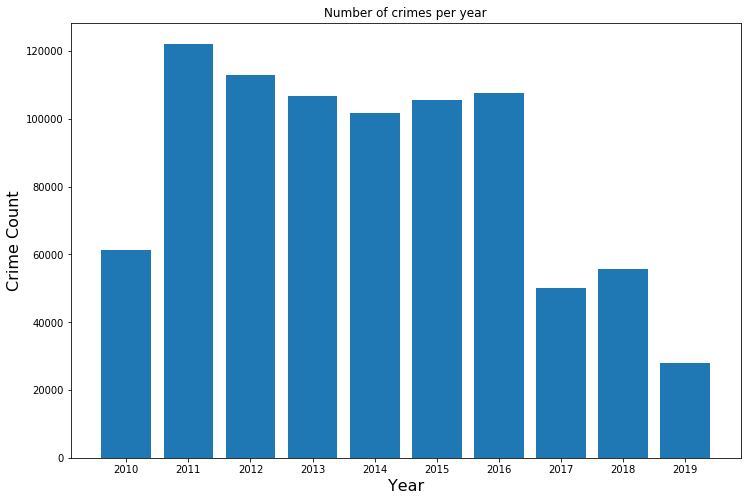

In [86]:
# Plotting the graph for number of crimes per year 

y_list = [int(row.crime_count) for row in py_df.select('crime_count').collect()]
x_list = [int(row.yr) for row in py_df.select('yr').collect()]

plt.figure(figsize=(12,8))
plt.bar(x_list,y_list)
plt.xlabel('Year', fontsize=16)
plt.xticks(x_list)
plt.ylabel('Crime Count',fontsize=16)
plt.title('Number of crimes per year',fontsize=18)
plt.show()

* From the above graph we can observe that the years 2011 to 2016 were the years with high frequency of criminal offences.
* After 2016 there has been a huge decline in the number of crimes.

### Find the number of crimes per month. Plot the graph and explain your understanding of the graph.

In the below code we are making a new dataframes with only reported month and offence count. 

In [ ]:
temp1_df = crime_count_df.select(col('Reported Month').alias('mon'), col('Offence Count').alias('offence'))
pm_df = temp1_df.filter(temp1_df.offence.isNotNull()).groupBy('mon').agg(sum('offence').alias("crime_count")).orderBy('mon')

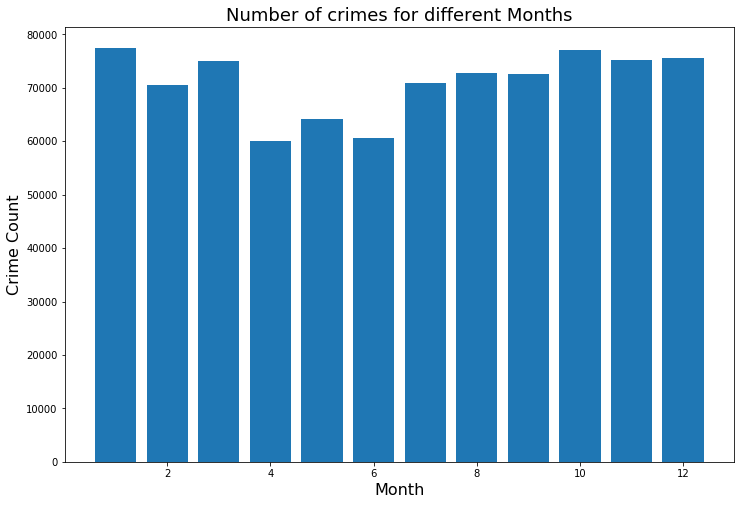

In [87]:
# # Plotting the graph for number of crimes per month 
y_m_list = [int(row.crime_count) for row in pm_df.select('crime_count').collect()]
x_m_list = [int(row.mon) for row in pm_df.select('mon').collect()]

plt.figure(figsize=(12,8))
plt.bar(x_m_list,y_m_list)
plt.xlabel('Month',fontsize=16)
plt.ylabel('Crime Count',fontsize=16)
plt.title('Number of crimes for different Months',fontsize=18)
plt.show()

From the above visualisation we can see that there has been almost a uniform distribution in number of crimes per month ranging from 60000 to about 80000 crimes per month.

### Where do most crimes take place? Find the top 20 suburbs (which would also display postcode for e.g. Caulfield-3162 )?  Plot the graph and explain your understanding of the graph.

In [140]:
# Finding the top 20 suburbs in the order of the number of crimes
th_df = crime_count_df.select(col('Suburb - Incident').alias('city'),col('Postcode - Incident').alias('post'),col('Offence Count').alias('offence'))
pl_df = th_df.filter( th_df.post.isNotNull()).filter(th_df.post!='NOT DISCLOSED').select(concat('city',lit('-'),'post').alias('Suburb'),'offence').groupBy('Suburb').agg(sum('offence').alias('offence')).orderBy('offence',ascending=False).limit(20)
print('Top twenty suburbs in offence :')
pl_df.show()

Top twenty suburbs in offence
+--------------------+-------+
|              Suburb|offence|
+--------------------+-------+
|       ADELAIDE-5000|  46701|
|   PORT AUGUSTA-5700|  13711|
|  MOUNT GAMBIER-5290|  13709|
|  MURRAY BRIDGE-5253|  12919|
|  MORPHETT VALE-5162|  12569|
|      SALISBURY-5108|  10806|
|   PORT LINCOLN-5606|  10779|
|      ELIZABETH-5112|  10731|
|   DAVOREN PARK-5113|   8082|
|PARAFIELD GARDENS...|   8040|
|  OAKLANDS PARK-5046|   7792|
|      PARALOWIE-5108|   7261|
|       PROSPECT-5082|   7234|
|     PORT PIRIE-5540|   7155|
|        MODBURY-5092|   7041|
|     SMITHFIELD-5114|   7000|
|SALISBURY NORTH-5108|   6538|
| WHYALLA STUART-5608|   6297|
|   MAWSON LAKES-5095|   6103|
| WHYALLA NORRIE-5608|   5837|
+--------------------+-------+



In [141]:
# Using list comprehension to get values used to later plot graph
y_c_list = [int(row.offence) for row in pl_df.select('offence').collect()]
x_c_list = [row.Suburb for row in pl_df.select('Suburb').collect()]


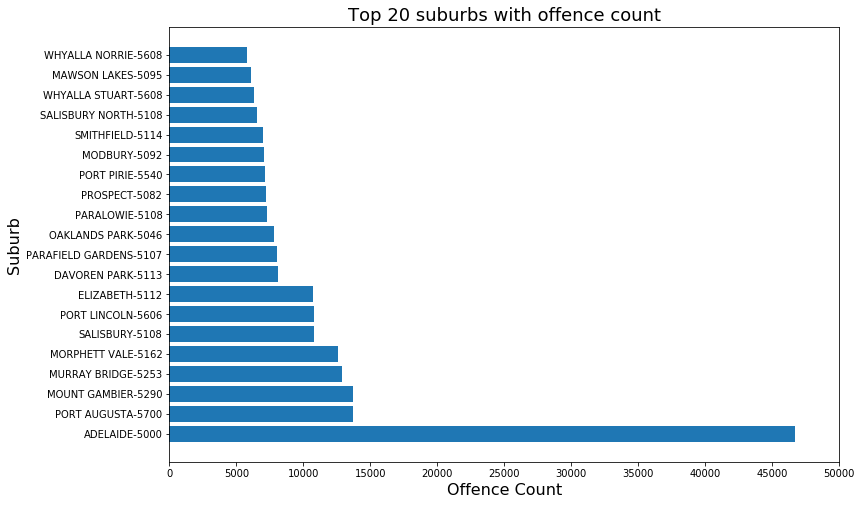

In [142]:
# Plotting the graph of top 20 suburbs with their offence count
plt.figure(figsize=(12,8))
plt.barh(x_c_list,y_c_list)
plt.ylabel('Suburb',fontsize=16)
plt.xlabel('Offence Count',fontsize=16)
plt.xticks(range(0,55000,5000))
plt.title('Top 20 suburbs with offence count',fontsize=18)
plt.show()


In [ ]:
print('Most crimes take place in',x_c_list[0])

From the above visualisation we observe that Adelaide has the highest number of offences, which is more that twice compared to each of the other suburbs.

### Find the number of serious criminal trespasses by day and month. Plot a graph and explain your understanding of the graph.

In [ ]:
import datetime
import calendar

ff_df = crime_count_df.select(col('Reported Date').alias('date'),col('Reported Month').alias('mon'),col('Offence Level 2 Description').alias('l2'),col('Offence Count').alias('offence'))
ff_df=ff_df.filter(ff_df.offence.isNotNull())


In [ ]:
from pyspark.sql.functions import udf,desc
from datetime import datetime

weekDay =  udf(lambda x: datetime.strptime(x, '%d/%m/%Y').strftime('%w'))

dow_df = ff_df.withColumn('dow', weekDay(ff_df['date'])).filter(ff_df.l2=='SERIOUS CRIMINAL TRESPASS').groupBy(['mon','dow']).agg(sum('offence').alias('offence')).orderBy(['dow','mon'])

In [ ]:
y_f_list = [int(row.offence) for row in dow_df.select('offence').collect()]

In [ ]:

import numpy as np
final_list=[]
j=0
for i in range(7):
    w_l=[]
    for k in range(12):
        w_l.append(y_f_list[j])
        j+=1
    final_list.append(w_l)

rang=[]
for o in range(7):
    l1=[]
    for j in range(12):
        l1.append(j+o*1.25)
    rang.append(l1)

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
r1=np.arange(12)
r2 = [x + 0.125 for x in r1]
r3 = [x + 0.125 for x in r2]
r4 = [x + 0.125 for x in r3]
r5 = [x + 0.125 for x in r4]
r6 = [x + 0.125 for x in r5]
r7 = [x + 0.125 for x in r6]

In [ ]:
plt.figure(figsize=(18,8))

plt.bar(r1, final_list[0], color='teal', width=0.125, edgecolor='white', label='Sunday')
plt.bar(r2, final_list[1], color='red', width=0.125, edgecolor='white', label='Monday')
plt.bar(r3, final_list[2], color='blue', width=0.125, edgecolor='white', label='Tuesday')
plt.bar(r4, final_list[3], color='green', width=0.125, edgecolor='white', label='Wednesday')
plt.bar(r5, final_list[4], color='orange', width=0.125, edgecolor='white', label='Thursday')
plt.bar(r6, final_list[5], color='cyan', width=0.125, edgecolor='white', label='Friday')
plt.bar(r7, final_list[6], color='yellow', width=0.125, edgecolor='white', label='Saturday')
plt.xlabel('Months')
plt.legend()
plt.ylabel('Number of SERIOUS CRIMINAL TRESPASS')
plt.xticks([r + 0.125 for r in range(12)], months)
plt.title('Top 20 suburbs with offence count',fontsize=18)

plt.show()



From the above graph we can see that second day of the week of each month has the highest number of serious criminal trespasses compared to other days of the week.